In [1]:
import copy

import networkx as nx

from regraph.library.hierarchy import Hierarchy
from regraph.library.rules import Rule
from regraph.library.plotting import plot_graph, plot_instance, plot_rule
from regraph.library.primitives import find_matching, rewrite, print_graph
from regraph.library.utils import keys_by_value

import matplotlib.pyplot as plt

## Simple graph rewriting

In [2]:
graph = nx.DiGraph()
graph.add_nodes_from([
    ('1', {'name': 'EGFR', 'state': 'p'}),
    ('2', {'name': 'BND'}),
    ('3', {'name': 'Grb2', 'aa': 'S', 'loc': 90}),
    ('4', {'name': 'SH2'}),
    ('5', {'name': 'EGFR'}),
    ('6', {'name': 'BND'}),
    ('7', {'name': 'Grb2'}),
    ('8', {'name': 'WAF1'}),
    ('9', {'name': 'BND'}),
    ('10', {'name': 'G1-S/CDK', 'state': 'p'}),
])
edges = [
    ('1', '2', {'s': 'p'}),
    ('4', '2', {'s': 'u'}),
    ('4', '3'),
    ('5', '6', {'s': 'p'}),
    ('7', '6', {'s': 'u'}),
    ('8', '9'),
    ('9', '8'),
    ('10', '8', {"a": {1}}),
    ('10', '9', {"a": {2}}),
    ('5', '2', {'s': 'u'})
]

graph.add_edges_from(edges)

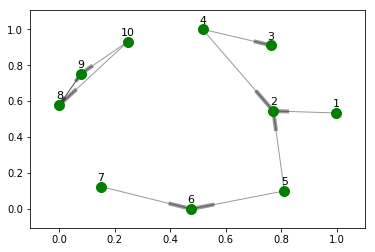

In [3]:
positioning = plot_graph(graph)

In [4]:
pattern = nx.DiGraph()
pattern.add_nodes_from(
    [(1, {'state': 'p'}),
     (2, {'name': 'BND'}),
     3,
     4]
)
pattern.add_edges_from(
    [(1, 2, {'s': 'p'}),
     (3, 2, {'s': 'u'}),
     (3, 4)]
)

p = nx.DiGraph()
p.add_nodes_from([
    (1, {'state': 'p'}),
    '1_clone',
    (2, {'name': 'BND'}),
    3,
    4
])
p.add_edges_from([
    (1, 2),
    ('1_clone', 2),
    (3, 4)
])

rhs = nx.DiGraph()
rhs.add_nodes_from([
    (1, {'state': 'p'}),
    '1_clone',
    (2, {'name': 'BND'}),
    3,
    4,
    5
])

rhs.add_edges_from([
    (1, 2, {'s': 'u'}),
    ('1_clone', 2),
    (2, 4),
    (3, 4),
    (5, 3)
])

p_lhs = {1: 1, '1_clone': 1, 2: 2, 3: 3, 4: 4}
p_rhs = {1: 1, '1_clone': '1_clone', 2: 2, 3: 3, 4: 4}

rule = Rule(p, pattern, rhs, p_lhs, p_rhs)
# plot_rule(rule)

Instances:
{1: '1', 2: '2', 3: '5', 4: '6'}


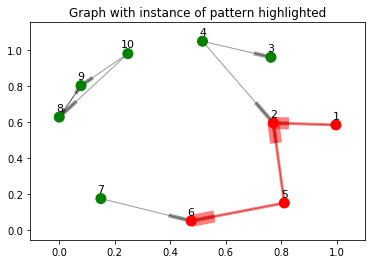

{1: '1', 2: '2', 3: '4', 4: '3'}


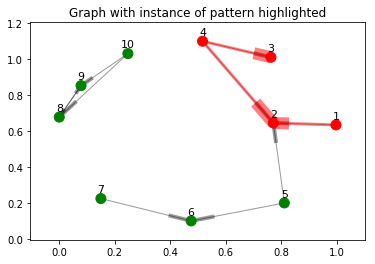

In [5]:
instances = find_matching(graph, rule.lhs)
print("Instances:")
for instance in instances:
    print(instance)
    plot_instance(graph, rule.lhs, instance, pos=positioning)

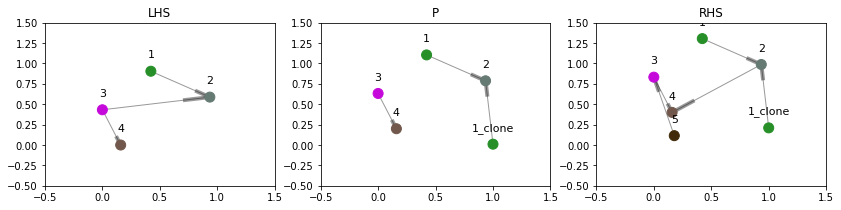

In [6]:
plot_rule(rule)

In [7]:
rewrite(graph, instances[0], rule)

{1: '1', 2: '2', 3: '5', 4: '6', 5: 5, '1_clone': '11'}

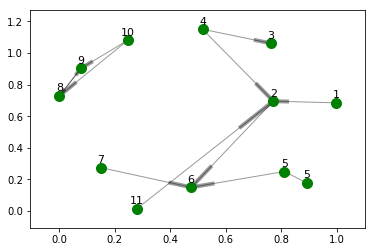

In [8]:
new_pos = plot_graph(graph, parent_pos=positioning)

## Hierarchy of graphs

In [9]:
hierarchy = Hierarchy()

colors = nx.DiGraph()
colors.add_nodes_from([
        "green", "red", "blue"
    ])
# colors.add_nodes_from([
#         ("green", {"r": 0, "g": 256, "b": 0}),
#         ("red", {"r": 256, "g": 0, "b": 0}),
#         ("blue", {"r": 0 "g": 0, "b": 256})
#     ])
colors.add_edges_from([
        ("red", "green"),
        ("red", "red"),
        ("green", "green"),
        ("blue", "red")
    ])
hierarchy.add_graph("colors", colors)

shapes = nx.DiGraph()
shapes.add_nodes_from(["circle", "square"])
shapes.add_edges_from([
        ("circle", "square"),
        ("square", "circle"),
        ("circle", "circle")
    ])
hierarchy.add_graph("shapes", shapes)

quality = nx.DiGraph()
quality.add_nodes_from(["good", "bad"])
quality.add_edges_from([
        ("bad", "bad"),
        ("bad", "good"),
        ("good", "good")
    ])
hierarchy.add_graph("quality", quality)

g1 = nx.DiGraph()
g1.add_nodes_from([
        "red_circle",
        "red_square",
        "green_circle",
        "green_square"
    ])
g1.add_edges_from([
        ("red_circle", "green_circle"),
        ("red_circle", "red_square"),
        ("red_circle", "red_circle"),
        ("red_square", "red_circle"),
        ("green_circle", "green_square"),
        ("green_square", "green_circle")
    ])
g1_colors = {
    "red_circle": "red",
    "red_square": "red",
    "green_circle": "green",
    "green_square": "green"
}
g1_shapes = {
    "red_circle": "circle",
    "red_square": "square",
    "green_circle": "circle",
    "green_square": "square"
}

hierarchy.add_graph("g1", g1)
hierarchy.add_typing("g1", "colors", g1_colors)
hierarchy.add_typing("g1", "shapes", g1_shapes)

g2 = nx.DiGraph()
g2.add_nodes_from([
        "good_circle",
        "good_square",
        "bad_circle",
        "bad_square"
    ])
g2.add_edges_from([
        ("good_circle", "good_square"),
        ("good_square", "good_circle"),
        ("bad_circle", "good_circle"),
        ("bad_square", "bad_circle"),
        ("bad_circle", "good_square"),
        ("bad_circle", "bad_circle")
    ])
g2_shapes = {
    "good_circle": "circle",
    "good_square": "square",
    "bad_circle": "circle",
    "bad_square": "square"
}
g2_quality = {
    "good_circle": "good",
    "good_square": "good",
    "bad_circle": "bad",
    "bad_square": "bad"
}

hierarchy.add_graph("g2", g2)
hierarchy.add_typing("g2", "shapes", g2_shapes)
hierarchy.add_typing("g2", "quality", g2_quality)

g3 = nx.DiGraph()
g3.add_nodes_from([
        "good_red_circle",
        "bad_red_circle",
        "good_green_square",
        "bad_green_circle",
        "good_red_square"
    ])
g3.add_edges_from([
        ("bad_red_circle", "good_red_circle"),
        ("bad_red_circle", "good_red_square"),
        ("bad_red_circle", "bad_green_circle"),
        ("bad_green_circle", "good_green_square"),
        ("good_red_square", "good_red_circle")
    ])

g3_g1 = {
    "good_red_circle": "red_circle",
    "bad_red_circle": "red_circle",
    "good_green_square": "green_square",
    "bad_green_circle": "green_circle",
    "good_red_square": "red_square"
}

g3_g2 = {
    "good_red_circle": "good_circle",
    "bad_red_circle": "bad_circle",
    "good_green_square": "good_square",
    "bad_green_circle": "bad_circle",
    "good_red_square": "good_square"
}

hierarchy.add_graph("g3", g3)
hierarchy.add_typing("g3", "g1", g3_g1)
hierarchy.add_typing("g3", "g2", g3_g2)

In [10]:
hierarchy.node_type("g3", "good_green_square")

['green_square', 'good_square']

In [11]:
lhs = nx.DiGraph()
lhs.add_nodes_from(["a", "b"])
lhs.add_edges_from([
        ("a", "b"),
        ("b", "a")
    ])
p = nx.DiGraph()
# p.add_nodes_from(["a", "b"])
p.add_nodes_from(["a", "a1", "b"])
p.add_edges_from([
        ("a", "b"),
        ("a1", "b")
    ])
rhs = copy.deepcopy(p)
rule = Rule(
    p, lhs, rhs,
#     {"a": "a", "b": "b"},
#     {"a": "a", "b": "b"},

    {"a": "a", "a1": "a", "b": "b"},
    {"a": "a", "a1": "a1", "b": "b"},
)

Instances:
{'a': 'circle', 'b': 'square'}


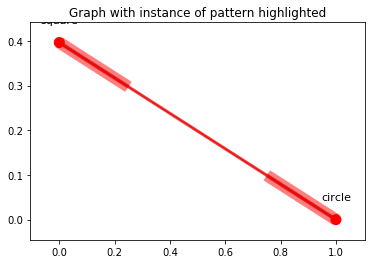

{'a': 'square', 'b': 'circle'}


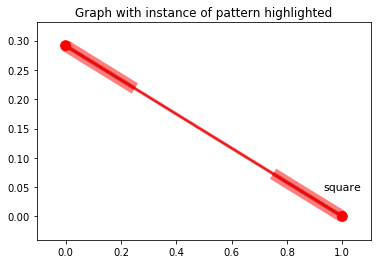

In [12]:
instances = hierarchy.find_matching("shapes", lhs)
print("Instances:")
for instance in instances:
    print(instance)
    plot_instance(hierarchy.node["shapes"], rule.lhs, instance)

In [13]:
hierarchy.rewrite("shapes", {"a": "circle", "b": "square"}, rule)

In [14]:
print_graph(hierarchy.node["shapes"])
print_graph(hierarchy.node["g1"])
print_graph(hierarchy.node["g2"])
print_graph(hierarchy.node["g3"])


Nodes:

circle1  :  {}
circle  :  {}
square  :  {}

Edges:

circle1 -> circle1  :  {}
circle1 -> circle  :  {}
circle1 -> square  :  {}
circle -> circle1  :  {}
circle -> circle  :  {}
circle -> square  :  {}

Nodes:

red_circle  :  {}
red_square  :  {}
green_circle  :  {}
red_circle1  :  {}
green_square  :  {}
green_circle1  :  {}

Edges:

red_circle -> red_circle  :  {}
red_circle -> green_circle1  :  {}
red_circle -> red_square  :  {}
red_circle -> green_circle  :  {}
red_circle -> red_circle1  :  {}
green_circle -> green_square  :  {}
red_circle1 -> red_circle  :  {}
red_circle1 -> green_circle1  :  {}
red_circle1 -> red_square  :  {}
red_circle1 -> green_circle  :  {}
red_circle1 -> red_circle1  :  {}
green_circle1 -> green_square  :  {}

Nodes:

good_circle  :  {}
bad_square  :  {}
bad_circle  :  {}
good_circle1  :  {}
good_square  :  {}
bad_circle1  :  {}

Edges:

good_circle -> good_square  :  {}
bad_circle -> good_circle  :  {}
bad_circle -> good_square  :  {}
bad_circle -> b